In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [21]:
len(words)

32033

In [22]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos);
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [23]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w +'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)   
    Y = torch.tensor(Y)   
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr= build_dataset(words[:n1])
Xdev, Ydev= build_dataset(words[n1:n2])
Xte, Yte= build_dataset(words[n2:])

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [24]:
n_embd = 10
n_hidden = 200

g= torch.Generator().manual_seed(2147483657)
C = torch.randn(vocab_size, n_embd,       generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden,  generator=g) * (5/3) /((n_embd * block_size)) **0.5
b1 = torch.randn(n_hidden, generator=g)*0.01
W2 = torch.randn(n_hidden, vocab_size,  generator=g) *0.01
b2 = torch.randn(vocab_size, generator=g) *0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, b1, W2, b2, bngain,bnbias]
parameters = [C, W1, W2, b2, bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of paramters in total
for p in parameters: 
    p.requires_grad = True;

12097


In [25]:
n_embd*block_size

30

In [26]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #forward pass
    emb=C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    
    bnmeani = hpreact.mean(0, keepdim=True)   #this one will be no grad
    bnstdi = hpreact.std(0, keepdim=True)   #this one will be no grad
    hpreact = bngain * (hpreact-bnmeani) / bnstdi + bnbias
    #hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0: # print every once in a white
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3020
  10000/ 200000: 2.5858
  20000/ 200000: 2.4725
  30000/ 200000: 2.4296
  40000/ 200000: 2.4608
  50000/ 200000: 2.4603
  60000/ 200000: 2.0381
  70000/ 200000: 2.1840
  80000/ 200000: 2.6346
  90000/ 200000: 2.0816
 100000/ 200000: 1.8624
 110000/ 200000: 2.0774
 120000/ 200000: 2.0420
 130000/ 200000: 1.9274
 140000/ 200000: 2.1415
 150000/ 200000: 2.0572
 160000/ 200000: 2.2397
 170000/ 200000: 1.8405
 180000/ 200000: 1.7918
 190000/ 200000: 2.5034


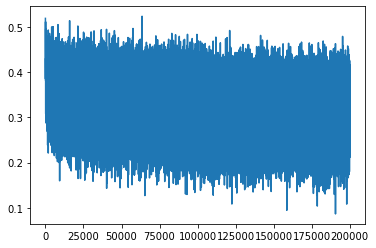

In [27]:
plt.plot(lossi)

In [28]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    # hpreact = embcat @ W1 + b1
    hpreact = embcat @ W1
    # measure the mean/std over the entrie training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [29]:
bnmean.shape

torch.Size([1, 200])

In [35]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)  
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.088106155395508
val 2.087653398513794
test 2.3572704792022705


In [36]:
block_size

3

In [38]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialze with all...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:]+[ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) # decode and print the generated word

charahzabryllerfkemrlkhlancahlandalejazcubbf.
prnystharquillermarttchadiv.
brgettbrhlmykoirtquxdannalilgik.
adbigobtelogijarquixfhxeendusabbestecotitgtyeleysandallasmberttqsynnndquoquoklylojlarylasdrendepfandlulonzombertondzh.
brigwandltynnnahkaquiloqugwy.
brostifermeltonbviollyxgarmesslymbkrlettazlilgin.
khlillakgurmosmltevlykyamawctoprowolttonmomokizllynlellezch.
br.
ellamillerossilicjoyfbaxyigugglydaquykdookynnksskarmyldda.
brgoldamauricksalmnyttquatzurulahrnglkndsontitslymdlummylkagtavphbndalpsavbrrkhermattocharnawabruswawdfledebthardoxdoxlehthulygil.
brucqubchujambrgbr.
brgittalyklamikabellyvabviammilicfbexlettitemrdredcajettiphmyaffexsson.
dot.
braddusevahmillaszder.
devaliahmarkideskealuditkmiliabrithadbettalassilex.
bricfixwiylynnndethadbellzondie.
brttevittyxkassilbphiktt.
farabthlynlamirchequrabbnygadielictlperkynnlchsthalabbtr.
briclebagtiemadebllzwredleigglynkgeomadyclunicksprlxzaddalucquddissaamadav.
taqusterigbgenihgitthikabrighlwdm.


In [39]:
torch.randn(4).sum()

tensor(0.0492)

In [40]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [52]:
X =  Xtr
X

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        ...,
        [15, 12,  4],
        [12,  4,  1],
        [ 4,  1, 14]])

In [53]:
C = torch.randn((27, 2))

In [54]:
emb = C[X]
emb.shape

torch.Size([182625, 3, 2])

In [55]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [56]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]])

tensor([[-0.5524, -0.1226],
        [-0.5524, -0.1226],
        [-0.5524, -0.1226],
        ...,
        [-0.9938,  0.2083],
        [-1.8277,  1.9224],
        [ 1.7081, -1.9015]])

In [57]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [58]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)


In [59]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [60]:
logits = h @ W2 + b2

In [61]:
logits.shape

torch.Size([182625, 27])

In [62]:
counts = logits.exp()

In [63]:
prob = counts / counts.sum(1, keepdims = True)
prob.shape

torch.Size([182625, 27])

In [65]:
Y = Ytr
Y.shape

torch.Size([182625])

In [66]:
prob[Y].shape

torch.Size([182625, 27])

In [68]:
em = C[X]
h = torch.tanh(em.view(-1, 6)@W1 + b1) #(32, 100)
logits = h@W2 +b2 #(32, 27
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(prob[Y].shape[0]), Y].log().mean()
loss

tensor(18.8179)

In [69]:
prob[0, Y[0]]

tensor(4.7430e-11)

In [70]:
F.cross_entropy(logits, Y)

tensor(18.8179)

In [71]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [72]:
sum(p.nelement() for p in parameters)

10281

In [73]:
for p in parameters:
    p.requires_grad = True

In [74]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [75]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] +[ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words) 
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [76]:
Y.shape

torch.Size([182625])

In [86]:
lri = []
lossi = []
stepi = []
for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass

    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -0.1 * p.grad

    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())
print(loss.item())

2.8757212162017822


In [87]:
emb.shape

torch.Size([32, 3, 2])

In [88]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6)@W1 + b1)
logits = h @W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.6124, grad_fn=<NllLossBackward0>)

In [89]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6)@W1 + b1)
logits = h @W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.6071, grad_fn=<NllLossBackward0>)

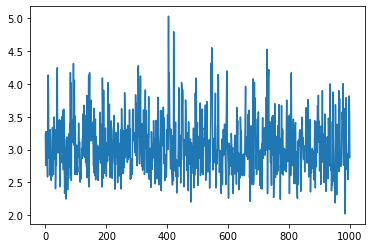

In [90]:
plt.plot(stepi, lossi)

In [91]:
torch.randint(0, X.shape[0], (32,))

tensor([ 69713, 112029, 145525, 148115, 119231, 168783,  20587, 141157,  36438,
        120823, 154084, 128765,  20735,  84154,  35123,  44301,  21399, 128221,
         71761,  56803, 139083,  29652,  62195, 143229, 145820,  51086,  27105,
        175021,  99554,  55430,  11500, 155642])

In [92]:
# Run this line of code only for finding the learning rate
# plt.plot(lri, lossi)

In [93]:
C.shape

torch.Size([27, 2])

In [ ]:
# SUMMARY -----------

In [135]:
# Let's train a deeper network
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculat the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)     # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean * self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var * self.momentum  * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
n_embd = 10 # the dimensionality of the charcater embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),                   generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   vocab_size),BatchNorm1d(vocab_size),
]
# with torch.no_grad():
#     # last layer: make less confident
#     layers[-1].gamma *= 0.1      
#     # layers[-1].weight *= 0.1      #we use this for Non-batchNorma1d case
#     # all other layers: apply gain
#     for layer in layers[:-1]:
#         if isinstance(layer, Linear):
#             layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [136]:
# same optimization as last itme
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    if i >= 1000:
        break #

      0/ 200000: 4.0467


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.62%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.38%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.25%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

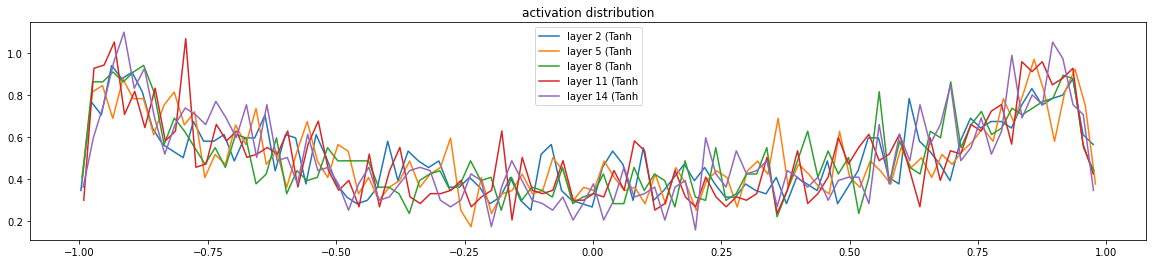

In [137]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.239441e-03
layer 5 (      Tanh): mean -0.000000, std 2.712597e-03
layer 8 (      Tanh): mean +0.000000, std 2.426119e-03
layer 11 (      Tanh): mean -0.000000, std 2.250670e-03
layer 14 (      Tanh): mean +0.000000, std 2.172576e-03


Text(0.5, 1.0, 'gradient distribution')

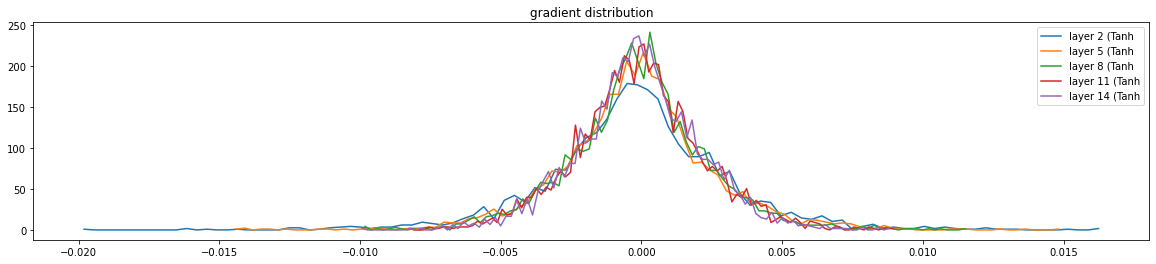

In [138]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.126155e-02 | grad:data ratio 1.124876e-02
weight  (30, 100) | mean +0.000100 | std 1.312022e-02 | grad:data ratio 6.893316e-02
weight (100, 100) | mean -0.000023 | std 9.373733e-03 | grad:data ratio 9.079345e-02
weight (100, 100) | mean +0.000089 | std 7.829066e-03 | grad:data ratio 7.588088e-02
weight (100, 100) | mean +0.000034 | std 7.070594e-03 | grad:data ratio 6.906897e-02
weight (100, 100) | mean +0.000080 | std 6.734416e-03 | grad:data ratio 6.578544e-02
weight  (100, 27) | mean -0.000085 | std 1.395012e-02 | grad:data ratio 1.300719e-01


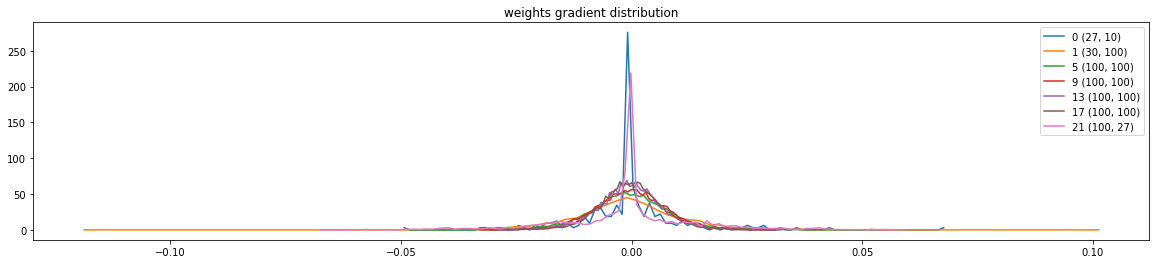

In [139]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [113]:
len(ud)

1001

In [114]:
Xtr.shape

torch.Size([182580, 3])

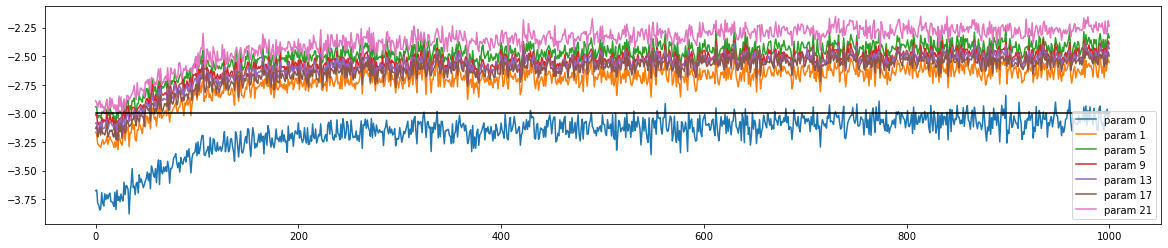

In [115]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

- Exercises Section
- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [ ]:
# Let's train a deeper network
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculat the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)     # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean * self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var * self.momentum  * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
n_embd = 10 # the dimensionality of the charcater embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),                   generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   vocab_size),BatchNorm1d(vocab_size),
]
# with torch.no_grad():
#     # last layer: make less confident
#     layers[-1].gamma *= 0.1      
#     # layers[-1].weight *= 0.1      #we use this for Non-batchNorma1d case
#     # all other layers: apply gain
#     for layer in layers[:-1]:
#         if isinstance(layer, Linear):
#             # layer.weight *= 5/3
#             layer.weight *= 0
#             layer.bias *=0
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [130]:
# same optimization as last itme
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    # if i >= 1000:
    #     break #

      0/ 200000: 2.9544
  10000/ 200000: 2.8094
  20000/ 200000: 2.7521
  30000/ 200000: 2.9756
  40000/ 200000: 2.7508
  50000/ 200000: 2.6817
  60000/ 200000: 2.7886
  70000/ 200000: 2.8725
  80000/ 200000: 2.9337
  90000/ 200000: 2.8139
 100000/ 200000: 2.6690
 110000/ 200000: 2.7799
 120000/ 200000: 2.7547
 130000/ 200000: 3.2180
 140000/ 200000: 2.8843
 150000/ 200000: 2.7387
 160000/ 200000: 2.7832
 170000/ 200000: 2.8930
 180000/ 200000: 3.0611
 190000/ 200000: 2.7252


layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

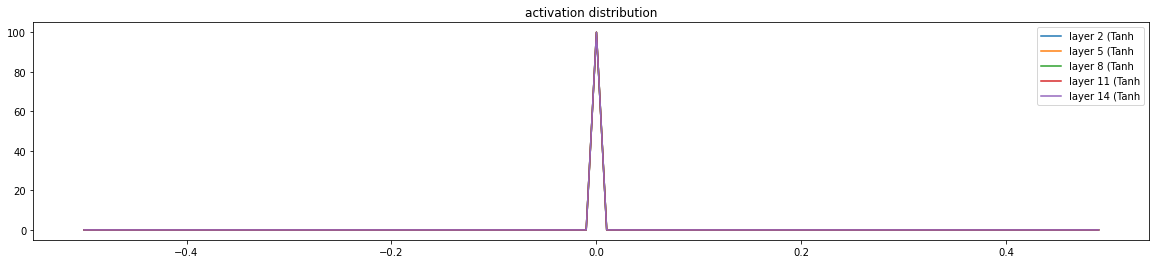

In [131]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

Compairing the activation distribution graph before, activation tends to be zero.
The saturated of Tanh is close to the 0%, which means the model is not predicting.

layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

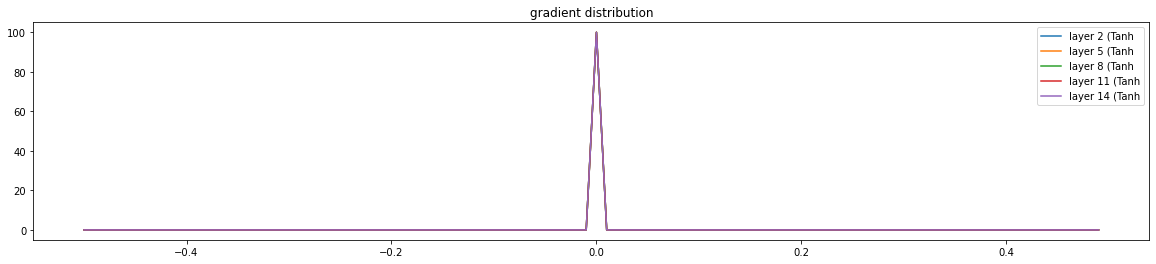

In [132]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

The gradient also becomes zero mostly. 

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


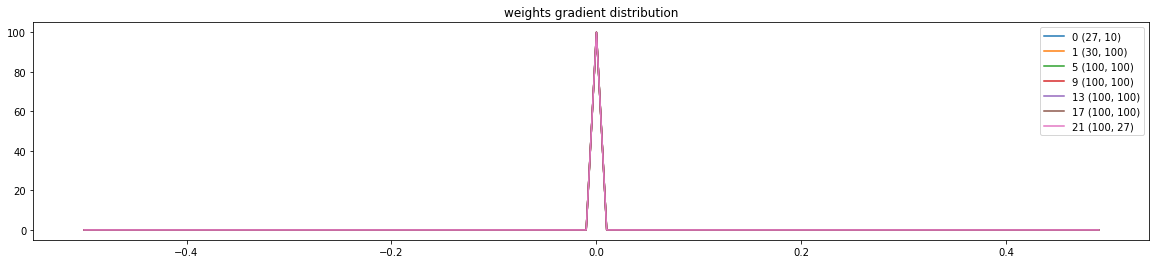

In [133]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

We can tell the model is not learning at all. The t.std()/p.std()) is the gradient of the scale of the trainable parameter of the linear layer per scale of the trainable parameters. It is getting close to zero into the later layers.

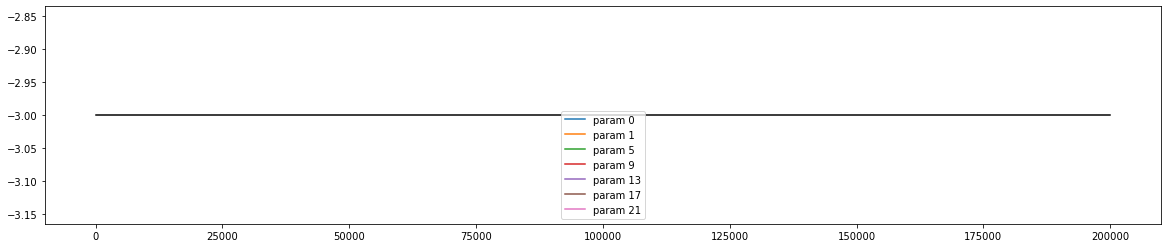

In [134]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

The model is not learning at all!

- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [175]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size ** 0.5)) #* 0.2

W2= torch.randn((n_hidden, n_hidden),            generator=g)
b2 = torch.randn(n_hidden,            generator=g)

W3 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b3 = torch.randn(vocab_size,            generator=g) * 0


parameters = [C, W1, W3, b3, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True



51897


In [176]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani =hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = ((hpreact - bnmeani) / bnstdi ) @ W2 + b2


  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W3 + b3 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.3042
  10000/ 200000: 2.5113
  20000/ 200000: 2.5545
  30000/ 200000: 2.1906
  40000/ 200000: 2.6238
  50000/ 200000: 2.4465
  60000/ 200000: 2.3780
  70000/ 200000: 2.2224
  80000/ 200000: 2.2692
  90000/ 200000: 2.2328
 100000/ 200000: 2.4313
 110000/ 200000: 2.2073
 120000/ 200000: 2.0927
 130000/ 200000: 1.8218
 140000/ 200000: 2.1955
 150000/ 200000: 1.8623
 160000/ 200000: 1.9946
 170000/ 200000: 2.1546
 180000/ 200000: 2.0279
 190000/ 200000: 1.9848


In [177]:
bnmean_running.shape, bnstd_running.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

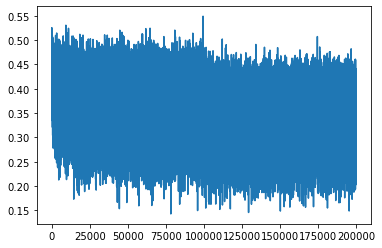

In [178]:
plt.plot(lossi)

In [179]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss_bn(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  # hpreact = ((hpreact - bnmean_running) / bnstd_running ) @ W2 + b2
  hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)@ W2 + b2
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W3 + b3 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss_bn('train')
split_loss_bn('val')

train 2.102692127227783
val 2.1350975036621094


In [180]:
# MLP 
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [181]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2856
  10000/ 200000: 2.1340
  20000/ 200000: 2.1373
  30000/ 200000: 2.2285
  40000/ 200000: 2.0133
  50000/ 200000: 1.7307
  60000/ 200000: 2.2741
  70000/ 200000: 2.2340
  80000/ 200000: 2.3828
  90000/ 200000: 2.0722
 100000/ 200000: 2.2072
 110000/ 200000: 2.1703
 120000/ 200000: 2.2788
 130000/ 200000: 1.8803
 140000/ 200000: 1.7875
 150000/ 200000: 2.1805
 160000/ 200000: 1.9339
 170000/ 200000: 1.9587
 180000/ 200000: 2.1038
 190000/ 200000: 2.0363


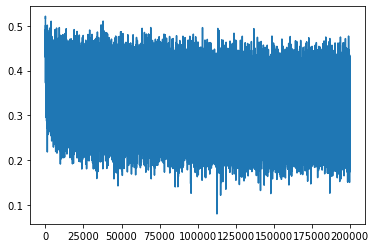

In [182]:
plt.plot(lossi)

In [185]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
#   hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0657238960266113
val 2.109697103500366


We can see removing the BatchNorm layer and using a linear layer will result:
train 2.102692127227783
val 2.1350975036621094

If we keep the BatchNorm layer, it will result:
train 2.0658464431762695
val 2.109297275543213